# 1. Data Preparation



## 1.1 Import and Prepare

import the dataset with features

In [ ]:
import pandas as pd 
import numpy as np 
import re

import warnings
warnings.filterwarnings(action="ignore")

In [ ]:
url = 'https://raw.githubusercontent.com/atinsinghal97/music-mood-analysis/main/song_features_clean.txt?token=AOEGKYKRUFCCOX4GLLUCND3ATGEOY'
features = pd.read_csv(url, encoding= 'unicode_escape' ,delimiter = '\t') 
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9976 entries, 0 to 9975
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   endTime           9976 non-null   object 
 1   artistName        9976 non-null   object 
 2   trackName         9976 non-null   object 
 3   msPlayed          9976 non-null   int64  
 4   id                9976 non-null   object 
 5   danceability      9976 non-null   float64
 6   energy            9976 non-null   float64
 7   key               9976 non-null   float64
 8   loudness          9976 non-null   float64
 9   mode              9976 non-null   float64
 10  speechiness       9976 non-null   float64
 11  acousticness      9976 non-null   float64
 12  instrumentalness  9976 non-null   float64
 13  liveness          9976 non-null   float64
 14  valence           9976 non-null   float64
 15  tempo             9976 non-null   float64
 16  type              9976 non-null   object 


In [ ]:
# keep only the features related to song, prepare for clustering
# since happy/sad is recoreded by in valence and calm/energic is recorded by energy, seperate them with rest of the features 
features_val_eng = features[['energy','valence']]
# features without valance and energy
features_cluster  = features[['danceability','loudness','speechiness','acousticness','instrumentalness','liveness','tempo']]

## 1.2 EDA

Visualize the distribution of each features

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('whitegrid')

import warnings
warnings.filterwarnings(action="ignore")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f00fe378d10>,
      dtype=object)

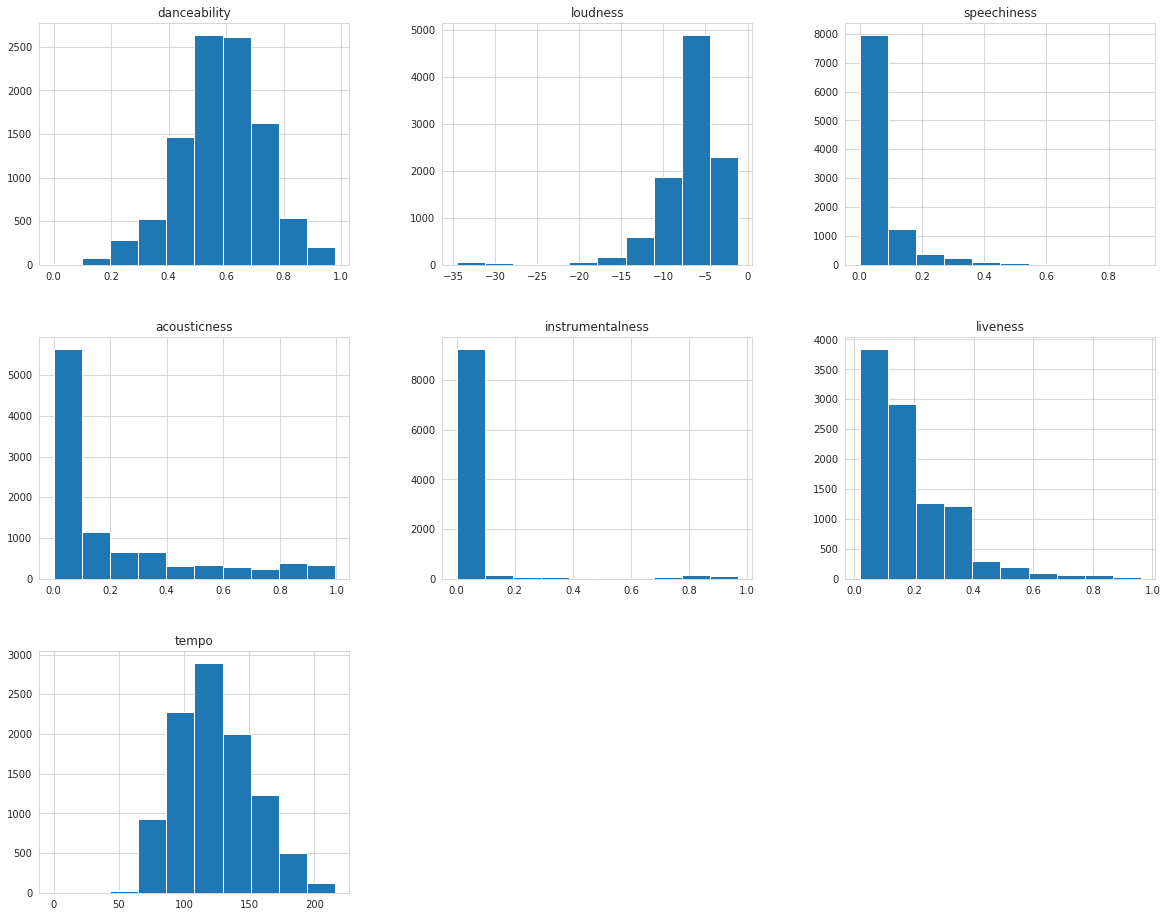

In [ ]:
# features other than valence and energy
features_cluster.hist(figsize=(20,16))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f00fc2c8290>,
      dtype=object)

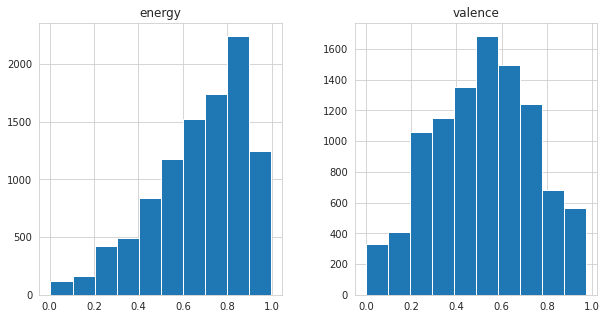

In [ ]:
# valence and energy
features_val_eng.hist(figsize=(10,5))

# 2. Cluster

## 2.1 Assign Cluster

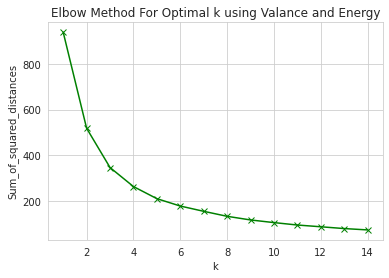

In [ ]:
# cluster based on Valance and Energy
from sklearn.cluster import KMeans

Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(features_val_eng)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'gx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k using Valance and Energy')
plt.show()

Based on Elbow Method, we would like to choose 4 as cut off since the slope starting to get stable k = 4. 

Other than this reason, we would like to classify the song from two aspects, happy/sad and energic/calm. Therefore, there exists 4 different emotional classes for each song:
+ happy and energic
+ happy and calm
+ sad and energic
+ sad and calm

Therefore 4 would be a perfect fit for us.

In [ ]:
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
features_val_eng['cluster'] = kmeans.fit_predict(features_val_eng)
features_cluster['cluster'] = kmeans.fit_predict(features_val_eng)

## 2.2 Visualize Cluster

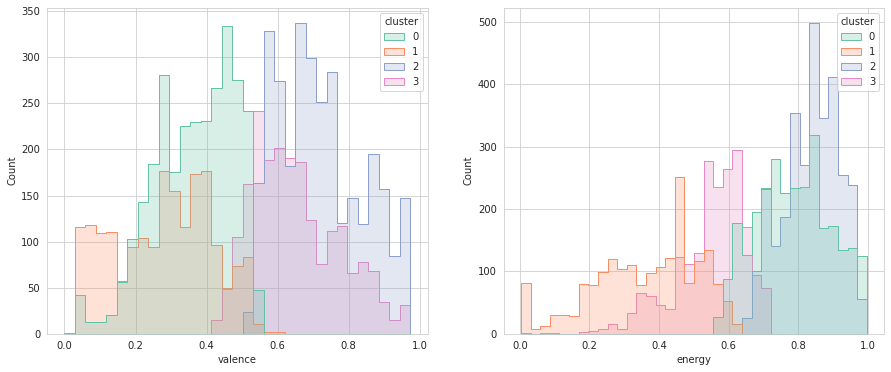

In [ ]:
# check the average of valance and energy to assign mood for cluster
fig,ax = plt.subplots(1,2, figsize = (15,6))
sns.histplot(features_val_eng, x = 'valence', hue = 'cluster', stat = 'count', element = 'step',palette = "Set2", ax = ax[0])
sns.histplot(features_val_eng, x = 'energy', hue = 'cluster', stat = 'count', element = 'step',palette = "Set2", ax = ax[1])

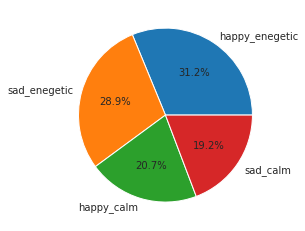

In [ ]:
count = np.array(features_cluster['cluster'].value_counts())
emotion_labels = ['happy_enegetic','sad_enegetic','happy_calm','sad_calm']
plt.pie(count, labels = emotion_labels, autopct='%1.1f%%')
plt.show() 

## 2.3 Add Happy and Energic Column based on Cluster

Since Happy and Energic are two different aspects for song, we would like to run two classification in the following process - one for happy/sad, one for energeic/calm.

In order to prepare for these two classification, we would like to add two extra columns to assign labels for these two classification. 

*Happy* is based on the previous cluster result in valance, we could see that:
  + cluster 0,1 have compariably low valance - happy = 0
  + cluster 2,3 have compariably high valance - happy = 1

*Energy* is based on the previous cluster result in energy, we could see that:
  + cluster 1,3 have compariably low energy - energy = 0
  + cluster 0,2 have compariably high energy - energy = 1

In [ ]:
# happy
features_cluster.loc[features_cluster['cluster'] == 0, 'happy'] = 0
features_cluster.loc[features_cluster['cluster'] == 1, 'happy'] = 0
features_cluster.loc[features_cluster['cluster'] == 2, 'happy'] = 1
features_cluster.loc[features_cluster['cluster'] == 3, 'happy'] = 1

# energy
features_cluster.loc[features_cluster['cluster'] == 0, 'energy'] = 1
features_cluster.loc[features_cluster['cluster'] == 1, 'energy'] = 0
features_cluster.loc[features_cluster['cluster'] == 2, 'energy'] = 1
features_cluster.loc[features_cluster['cluster'] == 3, 'energy'] = 0

In [ ]:
features_cluster.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9976 entries, 0 to 9975
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      9976 non-null   float64
 1   loudness          9976 non-null   float64
 2   speechiness       9976 non-null   float64
 3   acousticness      9976 non-null   float64
 4   instrumentalness  9976 non-null   float64
 5   liveness          9976 non-null   float64
 6   tempo             9976 non-null   float64
 7   cluster           9976 non-null   int32  
 8   happy             9976 non-null   float64
 9   energy            9976 non-null   float64
dtypes: float64(9), int32(1)
memory usage: 740.5 KB


In [ ]:
features_cluster['happy'].value_counts()/features_cluster.shape[0]

0.0    0.600942
1.0    0.399058
Name: happy, dtype: float64

In [ ]:
features_cluster['energy'].value_counts()/features_cluster.shape[0]

0.0    0.518845
1.0    0.481155
Name: energy, dtype: float64

# 3. Classification


## 3.1 Pre-Model

In [ ]:
features_cluster.describe()

,danceability,loudness,speechiness,acousticness,instrumentalness,liveness,tempo,cluster,happy,energy
count,9976.000000,9976.000000,9976.000000,9976.000000,9976.000000,9976.000000,9976.000000,9976.000000,9976.000000,9976.000000
mean,0.585088,-6.963859,0.074515,0.200484,0.043643,0.191037,123.825469,1.316961,0.399058,0.481155
std,0.144561,3.902609,0.077536,0.271651,0.168691,0.144287,28.919655,1.098907,0.489729,0.499670
min,0.000000,-34.587000,0.000000,0.000002,0.000000,0.017000,0.000000,0.000000,0.000000,0.000000
25%,0.494000,-8.245000,0.035100,0.006520,0.000000,0.095800,101.340250,0.000000,0.000000,0.000000
50%,0.588500,-6.048000,0.047200,0.063800,0.000003,0.134000,121.986000,1.000000,0.000000,0.000000
75%,0.682000,-4.529000,0.075000,0.306500,0.000509,0.258000,142.302000,2.000000,1.000000,1.000000
max,0.980000,-1.089000,0.905000,0.996000,0.970000,0.963000,216.053000,3.000000,1.000000,1.000000


### 3.1.1 Scale

In [ ]:
# since loudness and tempo have way larger range than that of the rest variables, scale them before modeling
# other than loudness  and tempe, rest features all in range [0,1]
# range of loudness is [-60,0]

from sklearn import preprocessing 
min_max_scale = preprocessing.MinMaxScaler()
features_cluster[['loudness','tempo']] = min_max_scale.fit_transform(features_cluster[['loudness','tempo']])

### 3.1.2 Imbalance

From the following results, we could see that __*energy*__ does not exist for imbalance issue. While for __*happy*__, the proportions between two classes are about 20% difference. We might want to balance the dataset first for happy before classification.

In [ ]:
print(features_cluster['happy'].value_counts()/features_cluster.shape[0])
print(features_cluster['energy'].value_counts()/features_cluster.shape[0])

0.0    0.600942
1.0    0.399058
Name: happy, dtype: float64
0.0    0.518845
1.0    0.481155
Name: energy, dtype: float64


In [ ]:
# import SMOTE for oversampling the dataset for predicting happy
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 42)

In [ ]:
# assign X and y for happy
X_happy = features_cluster.iloc[:,0:7]
y_happy = features_cluster['happy']

# apply smote on happy
X_happy_sm, y_happy_sm = sm.fit_resample(X_happy, y_happy)

# reformat the result to dataframe
X_happy_sm = pd.DataFrame(X_happy_sm)
y_happy_sm = pd.DataFrame(y_happy_sm)
X_happy_sm.columns = X_happy.columns
y_happy_sm.columns = ['happy']

# check the rebalanace result
print('\nBalance of positive and negative classes in happy (%):')
y_happy_sm.value_counts(normalize=True) * 100


Balance of positive and negative classes in happy (%):


happy
1.0      50.0
0.0      50.0
dtype: float64

## 3.2 Classification for Happy

In [ ]:
from sklearn.model_selection import train_test_split

# split for train and test, proportion = 75%
X_happy_train, X_happy_test, y_happy_train, y_happy_test = train_test_split(
    X_happy_sm, y_happy_sm, test_size=0.25, random_state=42
)

### 3.2.1 Logistic Regression

In [ ]:
# import the library
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
logreg = LogisticRegression()

# fit the model with data
logreg.fit(X_happy_train,y_happy_train)

# prediction for logistic
y_pred_log_h =logreg.predict(X_happy_test)

In [ ]:
# import the metrics class
from sklearn import metrics

# define confusion matix plot function
def confusion_matrix_plot(y_pred, y_test):
  pred_matrix = metrics.confusion_matrix(y_test, y_pred)

  class_names=[0,1] # name  of classes
  fig, ax = plt.subplots()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names)
  plt.yticks(tick_marks, class_names)
  # create heatmap

  sns.heatmap(pd.DataFrame(pred_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
  ax.xaxis.set_label_position("top")
  plt.tight_layout()
  plt.title('Confusion matrix', y=1.1)
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

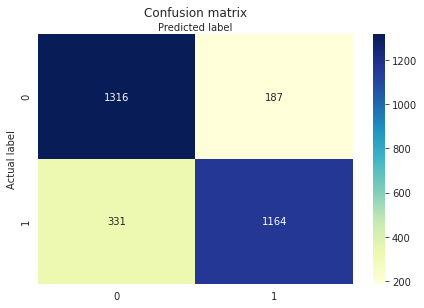

In [ ]:
confusion_matrix_plot(y_pred_log_h, y_happy_test)

No handles with labels found to put in legend.


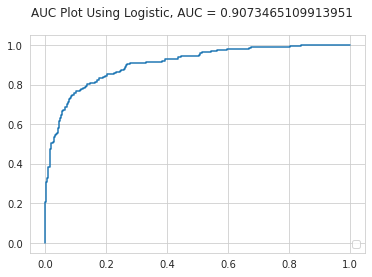

In [ ]:
# AUC plot
from sklearn import metrics

# find the probabilty for classification
y_pred_proba = logreg.predict_proba(X_happy_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_happy_test,  y_pred_proba)
auc_log = metrics.roc_auc_score(y_happy_test, y_pred_proba)

fig = plt.figure()
fig.suptitle('AUC Plot Using Logistic, AUC = ' + str(auc_log))
plt.plot(fpr,tpr)
plt.legend(loc=4)
plt.show()

# save probability for happy to the dataframe
happy_prob = pd.DataFrame(y_pred_proba)
happy_prob.columns = ['logistic']

In [ ]:
# accuracy, precision, recall and f1 will be chosen to evaluate model
result_col = ['model','accuracy','F1-score','AUC']

# create a result dataframe for model comparson
model_result_happy = []

In [ ]:
# define a function to save result for acc, f1 and auc 
def model_result(y_test, y_pred , auc, name, result):

  # get result
  acc = metrics.accuracy_score(y_test, y_pred)
  f1 = metrics.f1_score(y_test, y_pred)

  # print result
  print(name, "Accuracy:",acc)
  print(name,'F1-score',f1)

  #save into result dataframe
  new_row = [name,acc, f1,auc]
  result = result.append(new_row)


In [ ]:
model_result(y_happy_test,y_pred_log_h, auc_log,'logistic',model_result_happy)

logistic Accuracy: 0.8272181454302868
logistic F1-score 0.8179901616303585


### 3.2.2 Random Forest

#### 3.2.2.1 Using Default Hyperparameters

In [ ]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
rf=RandomForestClassifier(random_state=100)

#Train the model using the training sets
rf.fit(X_happy_train,y_happy_train)

# prediction
y_pred_rf_h = rf.predict(X_happy_test)

In [ ]:
from pprint import pprint

# get paramters from the default random forest
pprint(rf.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 100,
 'verbose': 0,
 'warm_start': False}


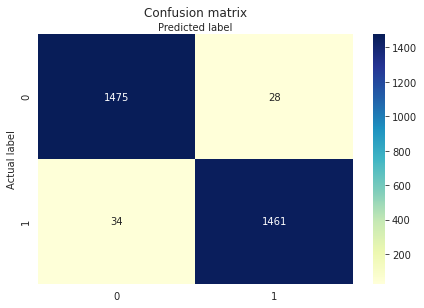

In [ ]:
# confusion matrix
confusion_matrix_plot(y_pred_rf_h, y_happy_test)

No handles with labels found to put in legend.


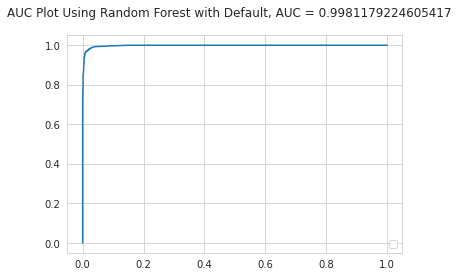

In [ ]:
# AUC plot
from sklearn import metrics

# find the probabilty for classification
y_pred_proba = rf.predict_proba(X_happy_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_happy_test,  y_pred_proba)
auc_rf = metrics.roc_auc_score(y_happy_test, y_pred_proba)

fig = plt.figure()
fig.suptitle('AUC Plot Using Random Forest with Default, AUC = ' + str(auc_rf))
plt.plot(fpr,tpr)
plt.legend(loc=4)
plt.show()

# save probability for happy to the dataframe
happy_prob['rf_default'] = pd.DataFrame(y_pred_proba)

In [ ]:
model_result(y_happy_test,y_pred_rf_h, auc_rf,'random_forest_default',model_result_happy)

random_forest_default Accuracy: 0.9793195463642428
random_forest_default F1-score 0.9792225201072385


Since we could see that the result with default is good enough for prediction. Therefore, there is no need to tune the hyperparameters.

### 3.2.3 XGBoosting

#### 3.2.3.1 Using Default Hyperparameters

In [ ]:
# import XGB model for classification
from xgboost import XGBClassifier

# create a model
xgb = XGBClassifier(seed = 1000)

# fit 
xgb.fit(X_happy_train, y_happy_train)

# predict
y_pred_xgb_h = xgb.predict(X_happy_test)

In [ ]:
# get paramters from the default random forest
pprint(xgb.get_params())

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 1000,
 'silent': None,
 'subsample': 1,
 'verbosity': 1}


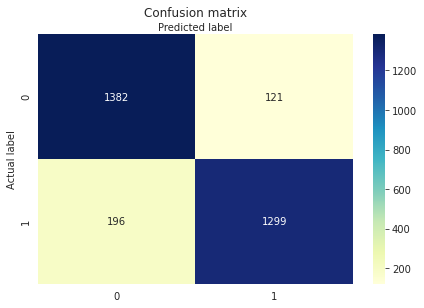

In [ ]:
# confusion matrix
confusion_matrix_plot(y_pred_xgb_h, y_happy_test)

No handles with labels found to put in legend.


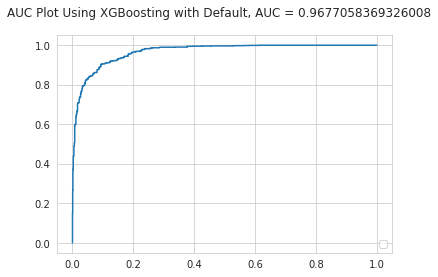

In [ ]:
# AUC plot
from sklearn import metrics

# find the probabilty for classification
y_pred_proba = xgb.predict_proba(X_happy_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_happy_test,  y_pred_proba)
auc_xgb = metrics.roc_auc_score(y_happy_test, y_pred_proba)

fig = plt.figure()
fig.suptitle('AUC Plot Using XGBoosting with Default, AUC = ' + str(auc_xgb))
plt.plot(fpr,tpr)
plt.legend(loc=4)
plt.show()

# save probability for happy to the dataframe
happy_prob['xgb_default'] = pd.DataFrame(y_pred_proba)

In [ ]:
model_result(y_happy_test,y_pred_xgb_h, auc_xgb,'xgb_default',model_result_happy)

xgb_default Accuracy: 0.8942628418945964
xgb_default F1-score 0.8912521440823328


#### 3.2.3.2 Tuning Hyperparameters

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# learning_rate - default = 0.1
learning_rate = [0.01,0.05,0.1,0.2]
# columns randomly selected at each tree - default  = 1
colsample_bytree = [0.5, 0.75, 1]
# sample selected for prediction at each split
subsample = [0.5, 0.75 , 1]

# Create the random grid
xgb_grid = {'learning_rate': learning_rate,
               'colsample_bytree': colsample_bytree,
               'subsample': subsample}

In [ ]:
# Use the grid to search for best hyperparameters

# define classifier
xgb = XGBClassifier(seed = 1000)

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
xgb_random = RandomizedSearchCV(estimator = xgb, param_distributions = xgb_grid, \
                               n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
xgb_random.fit(X_happy_train, y_happy_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:   29.9s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=1000, silent=None, subsample=1,
                                           verbosity=1),
                   iid='de

In [ ]:
# print the best hyperparameter
pprint(xgb_random.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.2, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1000,
              silent=None, subsample=0.5, verbosity=1)


In [ ]:
# fit the xgb with best esitmator
xgb_tune = xgb_random.best_estimator_
xgb_tune.fit(X_happy_train, y_happy_train)

# prediction with best estimator
y_pred_xgb_tune_h = xgb_tune.predict(X_happy_test)

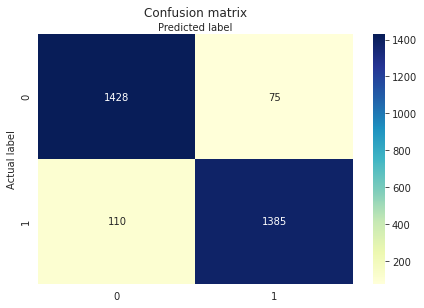

In [ ]:
# confusion matrix
confusion_matrix_plot(y_pred_xgb_tune_h, y_happy_test)

No handles with labels found to put in legend.


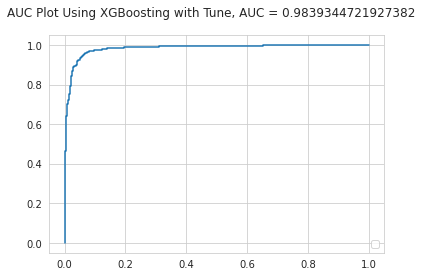

In [ ]:
# AUC plot
from sklearn import metrics

# find the probabilty for classification
y_pred_proba = xgb_tune.predict_proba(X_happy_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_happy_test,  y_pred_proba)
auc_xgb_tune = metrics.roc_auc_score(y_happy_test, y_pred_proba)

fig = plt.figure()
fig.suptitle('AUC Plot Using XGBoosting with Tune, AUC = ' + str(auc_xgb_tune))
plt.plot(fpr,tpr)
plt.legend(loc=4)
plt.show()

# save probability for happy to the dataframe
happy_prob['xgb_tune'] = pd.DataFrame(y_pred_proba)

In [ ]:
model_result(y_happy_test,y_pred_xgb_tune_h, auc_xgb_tune,'xgb_tune',model_result_happy)

xgb_tune Accuracy: 0.938292194796531
xgb_tune F1-score 0.937394247038917


### 3.2.3 Comparison

In [ ]:
model_result_happy = pd.DataFrame(model_result_happy, columns=result_col)
model_result_happy = model_result_happy.set_index('model')
model_result_happy

,accuracy,F1-score,AUC
model,,,
logistic,0.827218,0.817990,0.907347
random_forest_default,0.979320,0.979223,0.998118
xgb_default,0.894263,0.891252,0.967706
xgb_tune,0.938292,0.937394,0.983934


[Text(0.5, 1.0, 'Model Comparison')]

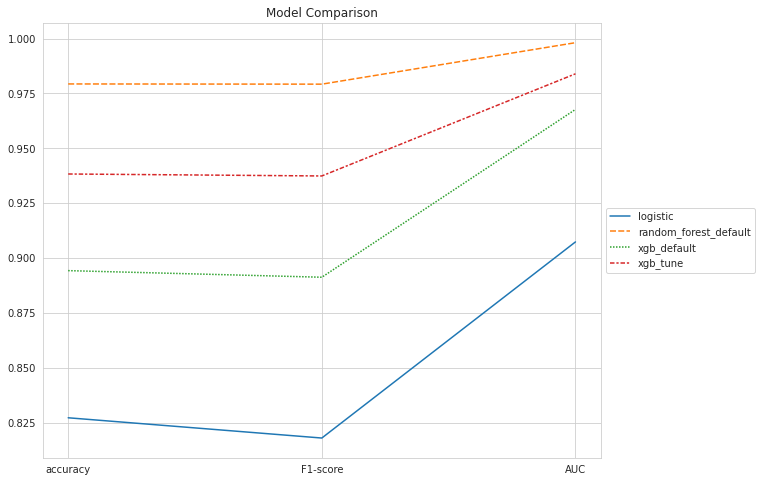

In [ ]:
fig = plt.subplots(figsize=(10,8))
p = sns.lineplot(data = model_result_happy.T)
p.legend(loc = 'center left', bbox_to_anchor=(1, 0.5))
p.set(title = 'Model Comparison')

We could see that random forest performs the best in predicting Happy for each song.

We here also would like to check the variable importance based on this best random forest model.

No handles with labels found to put in legend.


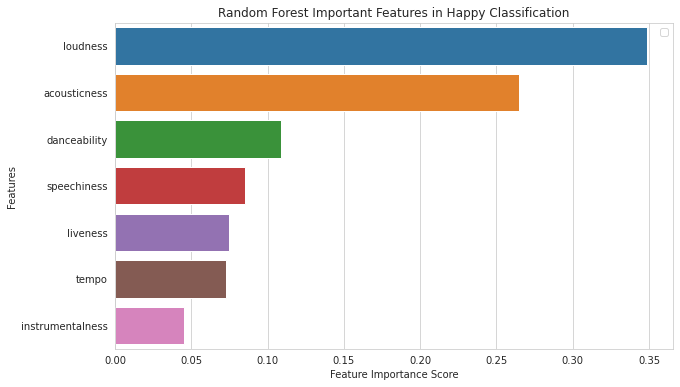

In [ ]:
# feature importance for random forest
feature_imp = pd.Series(rf.feature_importances_,index=X_happy_train.columns).sort_values(ascending=False)

# Creating a bar plot for feature importance top 20
plt.subplots(figsize=(10, 6))
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Random Forest Important Features in Happy Classification")
plt.legend()
plt.show()

In [ ]:
# save the best happy model
best_happy_model = rf

## 3.3 Classification for Energy

Since energy does not exist for imbalance problem, we can directly use the original dataset for prediction.

In [ ]:
features_cluster.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9976 entries, 0 to 9975
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      9976 non-null   float64
 1   loudness          9976 non-null   float64
 2   speechiness       9976 non-null   float64
 3   acousticness      9976 non-null   float64
 4   instrumentalness  9976 non-null   float64
 5   liveness          9976 non-null   float64
 6   tempo             9976 non-null   float64
 7   cluster           9976 non-null   int32  
 8   happy             9976 non-null   float64
 9   energy            9976 non-null   float64
dtypes: float64(9), int32(1)
memory usage: 740.5 KB


In [ ]:
# define x and y for energy
X_energy = features_cluster.iloc[:,0:7]
y_energy = features_cluster['energy']

In [ ]:
from sklearn.model_selection import train_test_split

# split for train and test, proportion = 75%
X_energy_train, X_energy_test, y_energy_train, y_energy_test = train_test_split(
    X_energy, y_energy, test_size=0.25, random_state=42
)

### 3.3.1 Logistic Regression

In [ ]:
# import the library
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
logreg_e = LogisticRegression()

# fit the model with data
logreg_e.fit(X_energy_train,y_energy_train)

# prediction for logistic
y_pred_log_e =logreg_e.predict(X_energy_test)

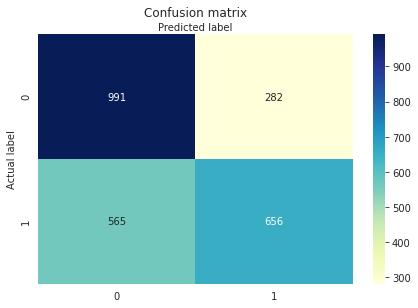

In [ ]:
confusion_matrix_plot(y_pred_log_e, y_energy_test)

No handles with labels found to put in legend.


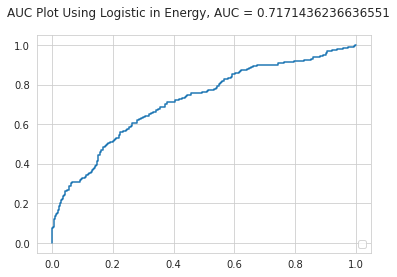

In [ ]:
# AUC plot
from sklearn import metrics

# find the probabilty for classification
y_pred_proba = logreg_e.predict_proba(X_energy_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_energy_test,  y_pred_proba)
auc_log = metrics.roc_auc_score(y_energy_test, y_pred_proba)

fig = plt.figure()
fig.suptitle('AUC Plot Using Logistic in Energy, AUC = ' + str(auc_log))
plt.plot(fpr,tpr)
plt.legend(loc=4)
plt.show()

# save probability for happy to the dataframe
energy_prob = pd.DataFrame(y_pred_proba)
energy_prob.columns = ['logistic']

In [ ]:
# accuracy, precision, recall and f1 will be chosen to evaluate model
result_col = ['model','accuracy','F1-score','AUC']

# create a result dataframe for model comparson
model_result_energy = []

In [ ]:
model_result(y_energy_test,y_pred_log_e, auc_log,'logistic',model_result_energy)

logistic Accuracy: 0.6603849238171612
logistic F1-score 0.6076887447892544


### 3.3.2 Random Forest

#### 3.3.2.1 Using Default Hyperparameters

In [ ]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
rf_e=RandomForestClassifier(random_state=100)

#Train the model using the training sets
rf_e.fit(X_energy_train,y_energy_train)

# prediction
y_pred_rf_e = rf_e.predict(X_energy_test)

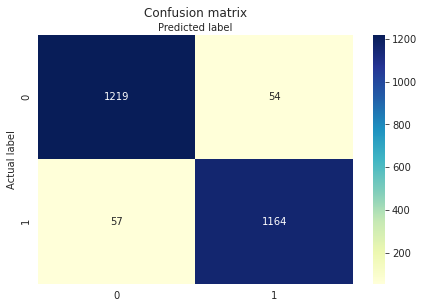

In [ ]:
confusion_matrix_plot(y_pred_rf_e, y_energy_test)

No handles with labels found to put in legend.


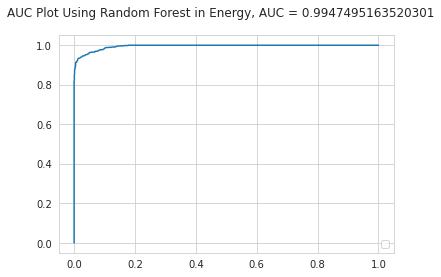

In [ ]:
# AUC plot
from sklearn import metrics

# find the probabilty for classification
y_pred_proba = rf_e.predict_proba(X_energy_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_energy_test,  y_pred_proba)
auc_rf = metrics.roc_auc_score(y_energy_test, y_pred_proba)

fig = plt.figure()
fig.suptitle('AUC Plot Using Random Forest in Energy, AUC = ' + str(auc_rf))
plt.plot(fpr,tpr)
plt.legend(loc=4)
plt.show()

# save probability for happy to the dataframe
energy_prob = pd.DataFrame(y_pred_proba)
energy_prob.columns = ['rf']

In [ ]:
model_result(y_energy_test,y_pred_rf_e, auc_rf,'random_forest',model_result_energy)

random_forest Accuracy: 0.9554931836407378
random_forest F1-score 0.954489544895449


Similarily to the previous result, since we could see that the result with default is good enough for prediction. Therefore, there is no need to tune the hyperparameters.

### 3.3.3 XGBoosting

#### 3.3.3.1 Using Default 

In [ ]:
# import XGB model for classification
from xgboost import XGBClassifier

# create a model
xgb_e = XGBClassifier(seed = 1000)

# fit 
xgb_e.fit(X_energy_train, y_energy_train)

# predict
y_pred_xgb_e = xgb_e.predict(X_energy_test)

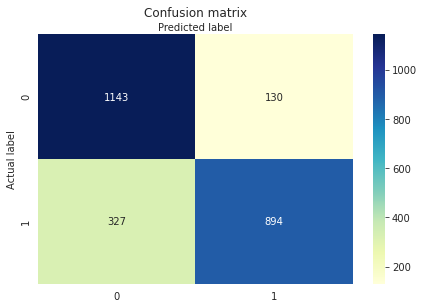

In [ ]:
# confusion matrix
confusion_matrix_plot(y_pred_xgb_e, y_energy_test)

No handles with labels found to put in legend.


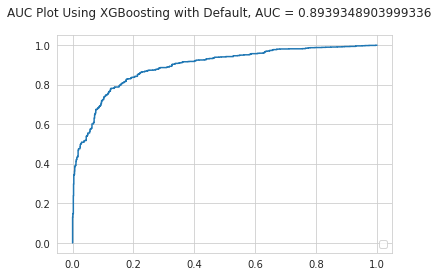

In [ ]:
# AUC plot
from sklearn import metrics

# find the probabilty for classification
y_pred_proba = xgb_e.predict_proba(X_energy_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_energy_test,  y_pred_proba)
auc_xgb = metrics.roc_auc_score(y_energy_test, y_pred_proba)

fig = plt.figure()
fig.suptitle('AUC Plot Using XGBoosting with Default, AUC = ' + str(auc_xgb))
plt.plot(fpr,tpr)
plt.legend(loc=4)
plt.show()

# save probability for happy to the dataframe
energy_prob['xgb_default'] = pd.DataFrame(y_pred_proba)

In [ ]:
model_result(y_energy_test,y_pred_xgb_e, auc_xgb,'xgb_default',model_result_energy)

xgb_default Accuracy: 0.8167602245388933
xgb_default F1-score 0.7964365256124721


#### 3.3.3.2 Tuning Hyperparameters

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# learning_rate - default = 0.1
learning_rate = [0.01,0.05,0.1,0.2]
# columns randomly selected at each tree - default  = 1
colsample_bytree = [0.5, 0.75, 1]
# sample selected for prediction at each split
subsample = [0.5, 0.75 , 1]

# Create the random grid
xgb_grid = {'learning_rate': learning_rate,
               'colsample_bytree': colsample_bytree,
               'subsample': subsample}

In [ ]:
# Use the grid to search for best hyperparameters

# define classifier
xgb_e = XGBClassifier(seed = 1000)

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
xgb_random_e = RandomizedSearchCV(estimator = xgb_e, param_distributions = xgb_grid, \
                               n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
xgb_random_e.fit(X_energy_train, y_energy_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:   24.2s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=1000, silent=None, subsample=1,
                                           verbosity=1),
                   iid='de

In [ ]:
# print the best hyperparameter
pprint(xgb_random_e.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.75, gamma=0,
              learning_rate=0.2, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1000,
              silent=None, subsample=0.75, verbosity=1)


In [ ]:
# fit the xgb with best esitmator
xgb_tune_e = xgb_random_e.best_estimator_
xgb_tune_e.fit(X_energy_train, y_energy_train)

# prediction with best estimator
y_pred_xgb_tune_e = xgb_tune_e.predict(X_energy_test)

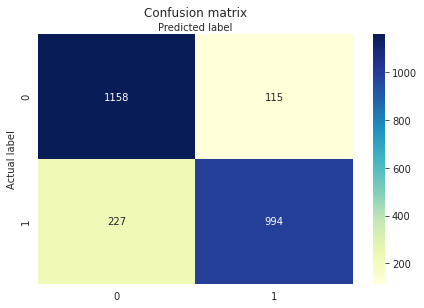

In [ ]:
# confusion matrix
confusion_matrix_plot(y_pred_xgb_tune_e, y_energy_test)

No handles with labels found to put in legend.


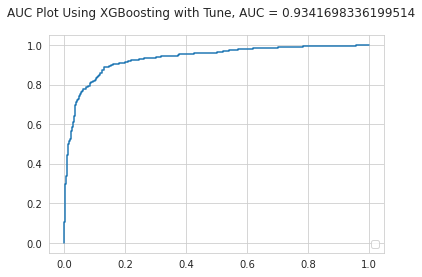

In [ ]:
# AUC plot
from sklearn import metrics

# find the probabilty for classification
y_pred_proba = xgb_tune_e.predict_proba(X_energy_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_energy_test,  y_pred_proba)
auc_xgb_tune = metrics.roc_auc_score(y_energy_test, y_pred_proba)

fig = plt.figure()
fig.suptitle('AUC Plot Using XGBoosting with Tune, AUC = ' + str(auc_xgb_tune))
plt.plot(fpr,tpr)
plt.legend(loc=4)
plt.show()

# save probability for happy to the dataframe
energy_prob['xgb_tune'] = pd.DataFrame(y_pred_proba)

In [ ]:
model_result(y_energy_test,y_pred_xgb_tune_e, auc_xgb_tune,'xgb_tune',model_result_energy)

xgb_tune Accuracy: 0.8628708901363272
xgb_tune F1-score 0.8532188841201717


### 3.3.4 Comparison

In [ ]:
model_result_energy = pd.DataFrame(model_result_energy, columns=result_col)
model_result_energy = model_result_energy.set_index('model')
model_result_energy

,accuracy,F1-score,AUC
model,,,
logistic,0.660385,0.607689,0.717144
random_forest,0.955493,0.954490,0.994750
xgb_default,0.816760,0.796437,0.893935
xgb_tune,0.862871,0.853219,0.934170


[Text(0.5, 1.0, 'Model Comparison for Energy')]

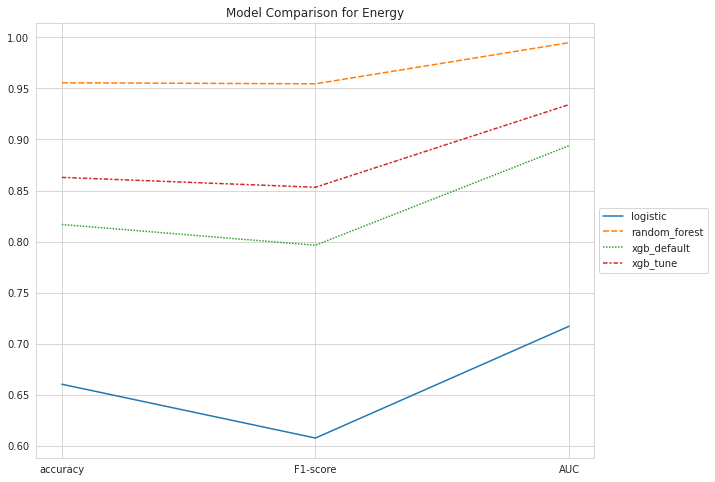

In [ ]:
fig = plt.subplots(figsize=(10,8))
p = sns.lineplot(data = model_result_energy.T)
p.legend(loc = 'center left', bbox_to_anchor=(1, 0.5))
p.set(title = 'Model Comparison for Energy')

Same as in Happy, random forest still provides the best classification based on accuracy, F1 and AUC.  Therefore, the best model would be chosen as random forest.

In [ ]:
# save the best happy model
best_energy_model = rf_e

No handles with labels found to put in legend.


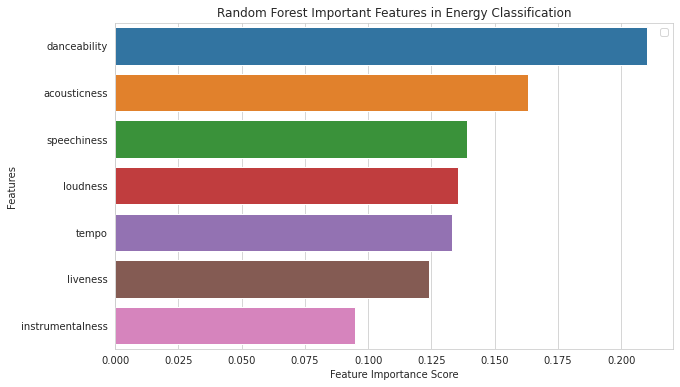

In [ ]:
# feature importance for random forest
feature_imp_e = pd.Series(rf_e.feature_importances_,index=X_energy_train.columns).sort_values(ascending=False)

# Creating a bar plot for feature importance top 20
plt.subplots(figsize=(10, 6))
sns.barplot(x=feature_imp_e, y=feature_imp_e.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Random Forest Important Features in Energy Classification")
plt.legend()
plt.show()

Let's compare this result with Happy classification:

In [ ]:
imp_compare = pd.DataFrame({'rank':list(range(1,8)),'Happy':list(feature_imp.index),
                           'Energy': list(feature_imp_e.index)})
imp_compare

,rank,Happy,Energy
0,1,loudness,danceability
1,2,acousticness,acousticness
2,3,danceability,speechiness
3,4,speechiness,loudness
4,5,liveness,tempo
5,6,tempo,liveness
6,7,instrumentalness,instrumentalness


Among the 7 features that these two classifications have, the top 4 feature importance contains the same variables but with different ranking.

danceability is the most important for energy which is reasonable from common sense. While loudness is the most important for happy.

As for the three least important for these two classification, instrumentalness is the at the bottom for both.

# 4. Map with color

## 4.1 Prediction Based on the most recent song

In [ ]:
# select the features for the most recent song 
features_final = features_cluster[features['endTime'] == features['endTime'].max()] \
                [['danceability','loudness','speechiness','acousticness','instrumentalness','liveness','tempo']]
features_final

,danceability,loudness,speechiness,acousticness,instrumentalness,liveness,tempo
9975,0.434,0.959818,0.0787,0.266,0.0,0.175,0.332391


In [ ]:
# classification prob for happy
happy_final = best_happy_model.predict_proba(features_final)[0][1]
# classification prob for energy
energy_final = best_energy_model.predict_proba(features_final)[0][1]

## 4.2 Plot

reference  
+ plan a: https://www.gopaintlove.org/mood-meter
+ plan b: https://www.shirinamouei.com/work/tangible-emotions/



In [ ]:
import urllib.request
from PIL import Image

url = 'https://images.squarespace-cdn.com/content/v1/54f4c335e4b0d713c23fdff3/1590782928259-O07XIQF8UGM4J84UI43S/ke17ZwdGBToddI8pDm48kKM1lTxJdyE_HE2HXwT7MW1Zw-zPPgdn4jUwVcJE1ZvWQUxwkmyExglNqGp0IvTJZamWLI2zvYWH8K3-s_4yszcp2ryTI0HqTOaaUohrI8PIyUAUzOb30eknSpRAogz9XhxFZJmNiZKolHftS71FPqEKMshLAGzx4R3EDFOm1kBS/IMG_3720.jpg?format=1500w'
image = Image.open(urllib.request.urlopen(url))

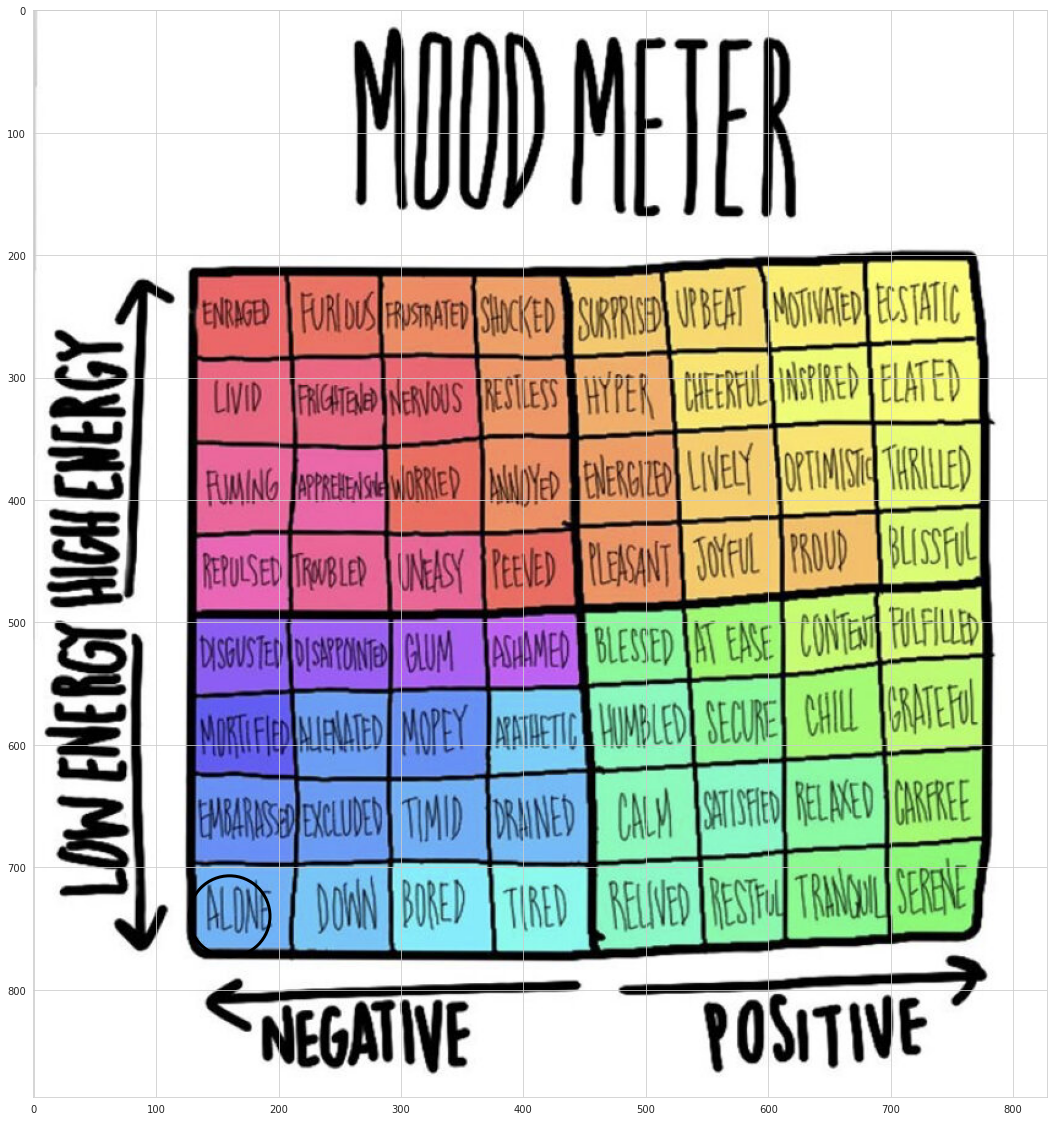

In [ ]:
import matplotlib.pyplot as plt
# img = plt.imread(image)
fig, ax = plt.subplots(figsize=(20,20))
ax.imshow(image)
circle = plt.Circle((160+happy_final*575,740 - energy_final*500), 33, color='black', fill=False,lw = 3)
ax.add_patch(circle)